# Production

In [1]:
# model.predict(np.array([[[74.11]],[[75.1]],[[66]]])) #prod structure



In [ ]:
# success configs:

# ticker = 'UNIP6.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

# ticker = 'KEPL3.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

# ticker = 'CSNA3.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

#============================================= parallel approach

# Parameters
# ticker = 'ITSA4.SA'
# start_date = '2023-01-01'
# train_end_date = '2023-12-31'
# val_end_date = '2024-06-30'
# end_date = '2024-11-29'
# window_size = 5

Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 170.2609 - mean_absolute_error: 12.9143 - val_loss: 121.0107 - val_mean_absolute_error: 10.9850
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 156.2914 - mean_absolute_error: 12.3692 - val_loss: 108.6573 - val_mean_absolute_error: 10.4076
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 143.4865 - mean_absolute_error: 11.8340 - val_loss: 92.5748 - val_mean_absolute_error: 9.6039
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 122.8195 - mean_absolute_error: 10.9178 - val_loss: 71.5208 - val_mean_absolute_error: 8.4368
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 96.1269 - mean_absolute_error: 9.6268 - val_loss: 45.0050 - val_mean_absolute_error: 6.6828
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 61.6569 - mean_absolute_error: 7.6181 - val_loss: 17.1834 - val_mean_absolute_error: 4.1030
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 29.0112 - mean_absolute_error: 4.9669

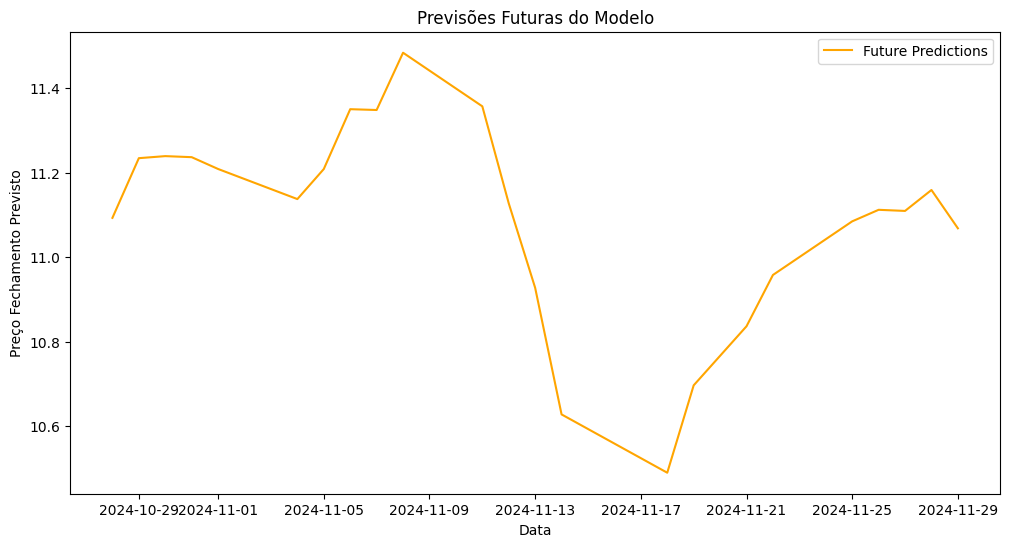

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Buscar preços reais
import plotly.graph_objects as go


# Função para converter string em datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


# Função para criar janelas de dados
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
            return None

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break

        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')

    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    
    return start_date, end_date

# Função para converter janela para entrada do modelo
def windowed_df_to_date_X_y(windowed_dataframe):
    if windowed_dataframe is None or windowed_dataframe.empty:
        raise ValueError("O DataFrame de janela está vazio ou é None. Verifique as entradas.")

    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


# Treinamento do modelo
def train_model(ticker, start_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period='max')
    df = df[['Close']]
    
    # Garantir que o índice seja datetime sem timezone e sem hora
    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()

    # Garantir que start_date e end_date também estejam normalizadas
    start_date = pd.to_datetime(start_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()

    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

    windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size)

    if windowed_df is None or windowed_df.empty:
        raise ValueError("Erro: df_to_windowed_df retornou um DataFrame vazio ou None.")

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    model = Sequential([
        layers.Input((window_size, 1)),
        layers.LSTM(70),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)

    return model, dates_test, X_test


# Parâmetros do modelo
ticker = 'CSNA3.SA'
start_date = '2024-01-08'
end_date = '2024-11-29'
window_size = 5

# Treinamento do modelo
model, dates_test, X_test = train_model(ticker, start_date, end_date, window_size)

# Predições para datas futuras
future_predictions = model.predict(X_test).flatten()

# Plot das previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(dates_test, future_predictions, label='Future Predictions', color='orange')
plt.title('Previsões Futuras do Modelo')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento Previsto')
plt.legend()
plt.show()
#=============== in case you have the data
def get_actual_prices(ticker, start_date, end_date):
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).normalize()
    return df


# Buscar preços reais
actual_prices_df = get_actual_prices(ticker, start_date, end_date)
actual_dates = actual_prices_df.index
actual_prices = actual_prices_df['Close'].to_numpy()

# Plot com Plotly
fig = go.Figure()

# Adicionar previsões futuras
fig.add_trace(go.Scatter(
    x=dates_test,
    y=future_predictions,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))

# Adicionar preços reais
fig.add_trace(go.Scatter(
    x=actual_dates,
    y=actual_prices,
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

# Layout do gráfico
fig.update_layout(
    title='Comparação entre Previsões e Preços Reais',
    xaxis_title='Data',
    yaxis_title='Preço Fechamento',
    legend=dict(x=0, y=1),
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)

# Mostrar gráfico
fig.show()


In [8]:
extended_dates

array([Timestamp('2024-01-08 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-09 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-10 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-11 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-12 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-15 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-16 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-17 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-18 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-19 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-22 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-23 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-24 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('2024-01-25 00:00:00-0300', tz='America/Sao_Paulo'),
       Timestamp('20

Sugestion to test in the future

In [ ]:
# import pandas as pd
# import numpy as np
# import datetime
# import yfinance as yf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping
# import plotly.graph_objects as go
# from sklearn.preprocessing import MinMaxScaler

# # Função para converter string em datetime
# def str_to_datetime(s):
#     split = s.split('-')
#     year, month, day = int(split[0]), int(split[1]), int(split[2])
#     return datetime.datetime(year=year, month=month, day=day)

# # Função para criar janelas de dados
# def df_to_windowed_df(dataframe, first_date_str, last_date_str, n, step=1):
#     first_date = str_to_datetime(first_date_str)
#     last_date = str_to_datetime(last_date_str)

#     target_date = first_date
#     dates = []
#     X, Y = [], []

#     while target_date <= last_date:
#         df_subset = dataframe.loc[:target_date].tail(n + 1)
#         if len(df_subset) != n + 1:
#             print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
#             break

#         values = df_subset['Close'].to_numpy()
#         x, y = values[:-1], values[-1]

#         dates.append(target_date)
#         X.append(x)
#         Y.append(y)

#         target_date += datetime.timedelta(days=step)

#     ret_df = pd.DataFrame({'Target Date': dates})
#     X = np.array(X)
#     for i in range(n):
#         ret_df[f'Target-{n-i}'] = X[:, i]
#     ret_df['Target'] = Y

#     return ret_df

# def adjust_dates_to_available(df, start_date, end_date):
#     if start_date not in df.index:
#         start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
#         print(f'Data inicial ajustada para {start_date}')

#     if end_date not in df.index:
#         end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
#         print(f'Data final ajustada para {end_date}')
    
#     return start_date, end_date

# # Função para converter janela para entrada do modelo
# def windowed_df_to_date_X_y(windowed_dataframe):
#     if windowed_dataframe is None or windowed_dataframe.empty:
#         raise ValueError("O DataFrame de janela está vazio ou é None. Verifique as entradas.")

#     df_as_np = windowed_dataframe.to_numpy()
#     dates = df_as_np[:, 0]
#     middle_matrix = df_as_np[:, 1:-1]
#     X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
#     Y = df_as_np[:, -1]

#     return dates, X.astype(np.float32), Y.astype(np.float32)

# # Treinamento do modelo
# def train_model(ticker, start_date, end_date, window_size):
#     df = yf.Ticker(ticker).history(period='max')
#     df = df[['Close']]
#     df.index = pd.to_datetime(df.index).tz_convert(None).normalize()
#     start_date = pd.to_datetime(start_date).normalize()
#     end_date = pd.to_datetime(end_date).normalize()

#     start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

#     scaler = MinMaxScaler()
#     df['Close'] = scaler.fit_transform(df[['Close']])

#     windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size, step=2)

#     if windowed_df is None or windowed_df.empty:
#         raise ValueError("Erro: df_to_windowed_df retornou um DataFrame vazio ou None.")

#     dates, X, y = windowed_df_to_date_X_y(windowed_df)

#     q_80 = int(len(dates) * .8)
#     q_90 = int(len(dates) * .9)

#     dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
#     dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
#     dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

#     model = Sequential([
#         layers.Input((window_size, 1)),
#         layers.LSTM(50, return_sequences=True, dropout=0.2),
#         layers.LSTM(30, dropout=0.2),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(1)
#     ])

#     model.compile(loss='mse',
#                   optimizer=Adam(learning_rate=0.001),
#                   metrics=['mean_absolute_error'])

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])

#     return model, dates_test, X_test, scaler

# def predict_with_uncertainty(f_model, X, scaler, n_iter=50):
#     pred_list = np.array([f_model(X, training=True).numpy().flatten() for _ in range(n_iter)])
#     pred_mean = scaler.inverse_transform(pred_list.mean(axis=0).reshape(-1, 1)).flatten()
#     pred_std = scaler.inverse_transform(pred_list.std(axis=0).reshape(-1, 1)).flatten()
#     return pred_mean, pred_std

# # Configurações
# ticker = 'UNIP6.SA'
# start_date = '2024-01-08'
# end_date = '2024-11-29'
# window_size = 5

# model, dates_test, X_test, scaler = train_model(ticker, start_date, end_date, window_size)
# future_mean, future_std = predict_with_uncertainty(model, X_test, scaler)

# # Buscar preços reais
# def get_actual_prices(ticker, start_date, end_date):
#     df = yf.Ticker(ticker).history(start=start_date, end=end_date)
#     df = df[['Close']]
#     df.index = pd.to_datetime(df.index).normalize()
#     return df

# actual_prices_df = get_actual_prices(ticker, start_date, end_date)
# actual_dates = actual_prices_df.index
# actual_prices = actual_prices_df['Close'].to_numpy()

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=dates_test, y=future_mean, mode='lines', name='Future Predictions', line=dict(color='orange')))
# fig.add_trace(go.Scatter(x=actual_dates, y=actual_prices, mode='lines', name='Actual Prices', line=dict(color='blue')))
# fig.show()
